The following description provides the context for all six questions that follow. The data is from various public sources so it can have inaccuracies and/or biases.

The data in the file **endsemData.csv** contains the number of terror incidents that happened between 2012 and 2015 in 100 countries. It also has various socio-political, economic, location and cultural attributes for those countries.

The 15 attributes are summarized below:

1. A unique numeric country code.
2. Country name.
3. A count of the number of terror incidents between 2012 and 2015.
4. GDP of the country.
5. Population of the country.
6. GDP per capita.
7. Religious diversity index.
8. Ethnic diversity index.
9. Linguistic diversity index.
10. Rule of law index.
11. Index for corruption.
12. Index for democracy.
13. Index for autocracy.
14. Region name (e.g. Asia, Europe etc.)
15. Region code (each region name above is associated with a numeric code).

Some indicies are inverted - that is a lower value of the index means a higher level of that attribute.

We want to build a model that will predict the number of terror incidents (dependent/ predicted variable) using the given attributes as potential predictor/ independent variables.



Data attributes that are inverted - that is a higher value of the index means a lower level of the attribute. 


In [ ]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm, t
import theano.tensor as tt

In [ ]:
data = pd.read_csv('Data.csv')
data

,cntryCode,country,count,gdp,population,gdpPerCapita,religion,ethnic,language,law,corruption,democracy,autocracy,region,regionCode
0,1,Afghanistan,6656,1.933100e+10,32526562,594.314272,0.2717,0.7693,0.6141,-1.672525,-1.432677,1,2,Asia,1
1,2,Albania,7,1.139800e+10,2889167,3945.081748,0.4719,0.2204,0.0399,-0.548157,-0.701515,9,0,Europe,2
2,3,Algeria,92,1.668390e+11,39666519,4206.040868,0.0091,0.3394,0.4427,-0.658459,-0.471443,3,1,Middle East & North Africa,3
3,4,Argentina,5,5.831690e+11,43416755,13431.888219,0.2236,0.2550,0.0618,-0.732617,-0.462757,9,0,South America,5
4,5,Armenia,3,1.052900e+10,3017712,3489.067214,0.4576,0.1272,0.1291,-0.316484,-0.461841,5,0,Asia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,122,Ukraine,1541,9.061500e+10,45198200,2004.836476,0.6157,0.4737,0.4741,-0.818289,-1.094172,5,1,Europe,2
96,124,United Kingdom,406,2.858003e+12,65138232,43875.968264,0.6944,0.1211,0.0532,1.684359,1.694164,10,0,Europe,2
97,125,United States,100,1.803665e+13,321418820,56115.718426,0.8241,0.4901,0.2514,1.546544,1.293073,10,0,North America,4
98,126,Uzbekistan,1,6.673300e+10,31299500,2132.078787,0.2133,0.4125,0.4120,-1.198077,-1.225589,0,9,Asia,1


A count of the number of terror incidents between 2012 and 2015 - not inverted (more in countries of Ukraine, Somalia, Iraq, Afghanistan)

GDP of the country - not inverted (Higher for India, Australia, China)

Population of the country - not inverted (Higher for India and China)

GDP per capita not inverted (Division of above two parameters)

Religious diversity index - not inverted (very low for countries with largely one religion, e.g., Algeria, Bangladesh etc.)

Ethnic diversity index - not inverted (very low for Bangladesh and it has 99.1% one ethnicity population)

Linguistic diversity index -not inverted (high for India, low for countries like Ireland)

Rule of law index - not inverted (higher implies more ruled by law for eg, Canada and France)

Index for corruption - inverted (lower values implies higher democracy, Countries infamous for corruption like China and India have negative values)

Index for democracy - not inverted (higher implies more democratic nation, e.g. values for Australia and India)

Index for autocracy not inverted (higher for autocratic countries like Qatar and Saudi Arabia)

Visualizing the data to get a sense of which attributes are likely to be good predictors.

In [ ]:
data.corr()

,cntryCode,count,gdp,population,gdpPerCapita,religion,ethnic,law,corruption,democracy,autocracy,regionCode
cntryCode,1.000000,0.021866,0.093289,-0.038522,0.031723,0.002977,0.148773,-0.037213,-0.055484,-0.032178,0.044797,0.087066
count,0.021866,1.000000,-0.030297,0.158882,-0.148097,-0.056776,0.099288,-0.258331,-0.243790,-0.063944,-0.087369,-0.139726
gdp,0.093289,-0.030297,1.000000,0.536033,0.315484,0.223726,-0.156155,0.264007,0.238623,0.109778,-0.000698,-0.111980
population,-0.038522,0.158882,0.536033,1.000000,-0.054844,0.066170,-0.069260,-0.018818,-0.055741,-0.043067,0.076959,-0.173374
gdpPerCapita,0.031723,-0.148097,0.315484,-0.054844,1.000000,0.098113,-0.363204,0.838020,0.837582,0.352446,-0.031875,-0.325694
religion,0.002977,-0.056776,0.223726,0.066170,0.098113,1.000000,0.099354,0.161527,0.114951,0.174649,-0.075061,0.119493
ethnic,0.148773,0.099288,-0.156155,-0.069260,-0.363204,0.099354,1.000000,-0.454816,-0.434581,-0.263041,0.088046,0.525773
law,-0.037213,-0.258331,0.264007,-0.018818,0.838020,0.161527,-0.454816,1.000000,0.960054,0.482930,-0.174462,-0.373043
corruption,-0.055484,-0.243790,0.238623,-0.055741,0.837582,0.114951,-0.434581,0.960054,1.000000,0.482789,-0.193613,-0.326531
democracy,-0.032178,-0.063944,0.109778,-0.043067,0.352446,0.174649,-0.263041,0.482930,0.482789,1.000000,-0.819653,-0.029054


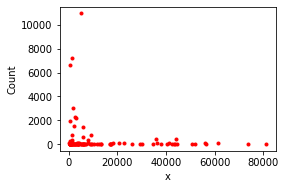

In [ ]:
fig = plt.figure(figsize = [3,2])
ax = fig.add_axes([0,0,1,1])
#ax.set_title("Posterior predictive samples of X")
ax.set_xlabel('x')
ax.set_ylabel('Count')

plt.plot(data['gdpPerCapita'],data['count'],'r.')
plt.show()

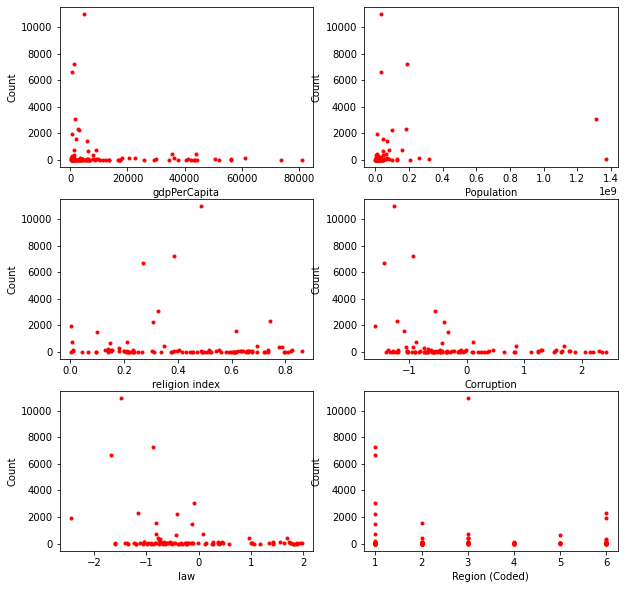

In [ ]:
figure, ax = plt.subplots(3, 2,figsize = [10,10])

ax[0,0].set_xlabel('gdpPerCapita')
ax[0,0].set_ylabel('Count')
ax[0, 0].plot(data['gdpPerCapita'], data['count'],'r.')
  
ax[0,1].set_xlabel('Population')
ax[0,1].set_ylabel('Count')
ax[0, 1].plot(data['population'], data['count'],'r.')

ax[1,0].set_xlabel('religion index')
ax[1,0].set_ylabel('Count')
ax[1, 0].plot(data['religion'], data['count'],'r.')

ax[1,1].set_xlabel('Corruption')
ax[1,1].set_ylabel('Count')
ax[1, 1].plot(data['corruption'], data['count'],'r.')

ax[2,0].set_xlabel('law')
ax[2,0].set_ylabel('Count')
ax[2, 0].plot(data['law'], data['count'],'r.')

ax[2,1].set_xlabel('Region (Coded)')
ax[2,1].set_ylabel('Count')
ax[2, 1].plot(data['regionCode'], data['count'],'r.')

plt.show()

Above Visualisation of parameters of gdpPerCapita shows that countries having high count of such incidents tend to have low gdpPerCapita. Converse is not true, as many countries with low gdp also have low count.

Visualisation for population and religion index shows no major trend.

Corruption plot shows that countries with high corruption rates (the values are inverted), tend to have higher count of incidents.

Similar observation can be inferred with law index.

Interestingly, the area plot shows that countries corresponding to Area Code -1(Asia) have relatively high count of incidents. Similar observation for 6(Sub-Saharan Countries) but with lesser count. 

Constructing a simple GLM model with population and GDP per capita as predictors. Estimating the parameters of the model using this model. Evaluation by calculating the mean squared error (RMSE) and the mean absolute error (MAE).

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

In [ ]:
X = data[['population', 'gdpPerCapita']]
y = data['count']

meanx = X.mean().values
sigmax = X.std().values
zX = ((X-meanx)/sigmax).values

inverse link function used - exponential distribution (as observed y is of discrete type)
i.e. 
$$\mu \:or\: y_{hat} = exp(\beta_0 + \beta_1 x_1 + \beta_2 x_2)$$
and Noise function used is of $Poisson$ type with $mean = \mu$.

In [ ]:
with pm.Model() as glm1:
  zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
  zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(2))
  mu = pm.math.exp(zbeta0 + pm.math.dot(zbetaj, zX.T))
  likelihood = pm.Poisson('likelihood', mu = mu, observed = y)

In [ ]:
with glm1:
  trace = pm.sample(10000, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [zbetaj, zbeta0]


Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.8907937193256991, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896989024820827, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c8575c5d0>,
      dtype=object)

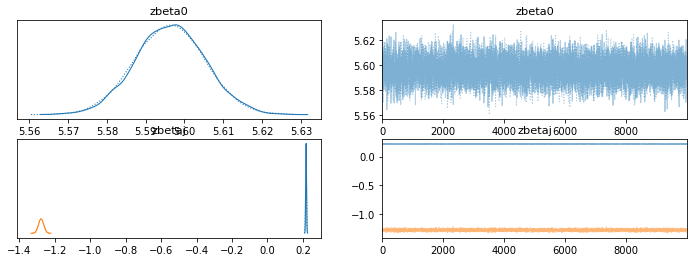

In [ ]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c7daf0f10>,
      dtype=object)

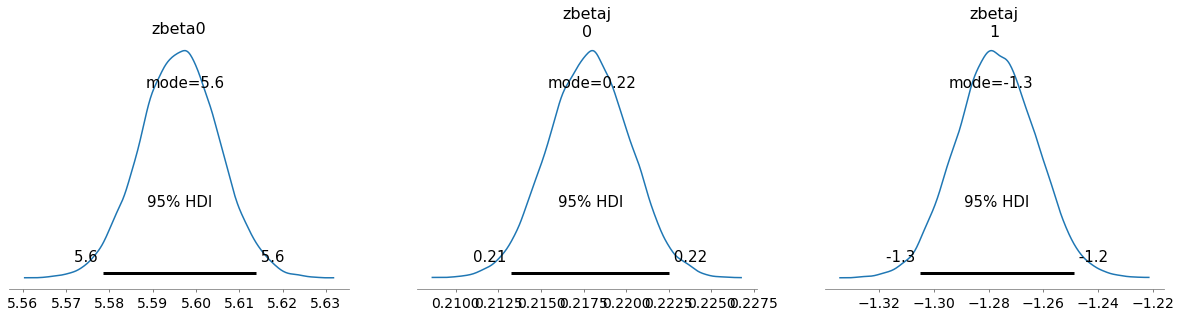

In [ ]:
az.plot_posterior(trace,['zbeta0','zbetaj'], hdi_prob=0.95, point_estimate='mode')

In [ ]:
zbeta0 = 5.6
zbeta1 = 0.22
zbeta2 = -1.3

mu = np.exp(zbeta0*np.ones(100) + zbeta1*zX[:,0] + zbeta2*zX[:,1])
RMSE = mean_squared_error(mu, y, squared = False)
MAE = mae(mu,y)
print('Mean Squared Error is :',RMSE,'Mean Absolute Error is : ',MAE)

Mean Squared Error is : 1469.3337435431906 Mean Absolute Error is :  636.4980666552542


Based on observations made in part 2, adding corruption might improve the model. Correlation Matrix of data shows high correlation between law and Corruption so adding that would make model worse. Also, gdpPerCapita and Corruption are correlated (nearly 0.8), so there would be changes in value of $\beta_1$.

In [ ]:
X_2 = data[['population', 'gdpPerCapita','corruption']]
y = data['count']

meanx_2 = X_2.mean().values
sigmax_2 = X_2.std().values
zX_2 = ((X_2-meanx_2)/sigmax_2).values

In [ ]:
with pm.Model() as glm2:
  zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
  zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(3))
  mu = pm.math.exp(zbeta0 + pm.math.dot(zbetaj, zX_2.T))
  likelihood = pm.Poisson('likelihood', mu = mu, observed = y)

In [ ]:
with glm2:
  trace2 = pm.sample(10000, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [zbetaj, zbeta0]


Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.9023603636857084, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9055064930023109, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c7cfd4050>,
      dtype=object)

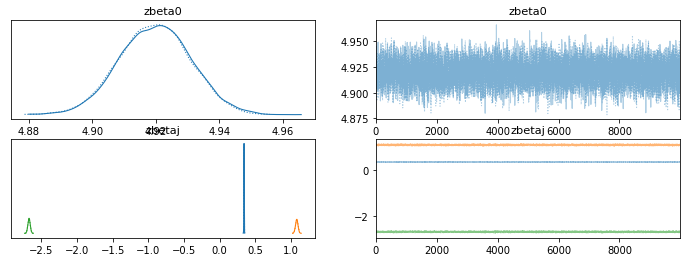

In [ ]:
az.plot_trace(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c7d132f10>,
      dtype=object)

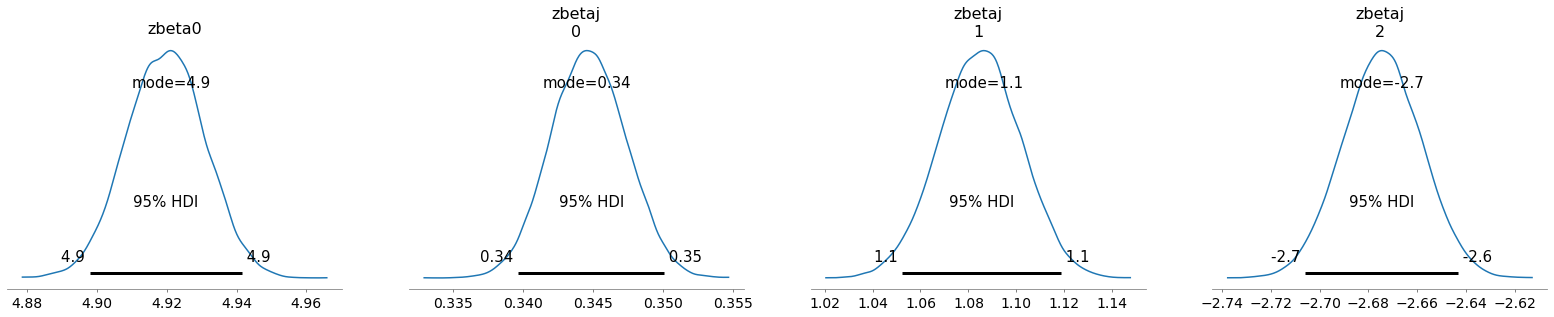

In [ ]:
az.plot_posterior(trace2,['zbeta0','zbetaj'], hdi_prob=0.95, point_estimate='mode')

In [ ]:
zbeta0 = 4.9
zbeta1 = 0.35
zbeta2 = 1.1
zbeta3 = -2.7
mu = np.exp(zbeta0*np.ones(100) + zbeta1*zX_2[:,0] + zbeta2*zX_2[:,1] + zbeta3*zX_2[:,2])
RMSE = mean_squared_error(mu, y, squared = False)
MAE = mae(mu,y)
print('Mean Squared Error is :',RMSE,'Mean Absolute Error is : ',MAE)

1368.5648143291328 567.0950387669781


Doing a posterior predictive check (PPC) of the two models in part 3 and part 4.

In [ ]:
n = 20000
samp_avg = np.ones(n)
dat_avg = np.mean(y)
beta0mat = trace['zbeta0']
beta1mat = trace['zbetaj'][:,0]
beta2mat = trace['zbetaj'][:,1]
for i in range(n):
  zbeta0 = np.random.choice(beta0mat)
  zbeta1 = np.random.choice(beta1mat)
  zbeta2 = np.random.choice(beta2mat)
  mu_samp = np.exp(zbeta0*np.ones(100) + zbeta1*zX[:,0] + zbeta2*zX[:,1])
  samp_avg[i] = np.mean(mu_samp) > dat_avg
print("Bayesian p- value for mean statistic ", np.mean(samp_avg))

Bayesian p- value for mean statistic  0.50415


Posterior Predictive Check done by Bayesian p test on some statistic of the original data and aritifically generated data. A value of 0.5 implies good modelling whereas a value of 0.0 or 1.0 implies poor modelling.

Above value shows that the GLM applied does model the behaviour of data well. 
Statistics of max and std can't be modelled well as the original data has many outliers. Bayesian models tend to move towards normalcy.


In [ ]:
n = 20000
samp_avg = np.ones(n)
dat_avg = np.mean(y)
beta0mat = trace2['zbeta0']
beta1mat = trace2['zbetaj'][:,0]
beta2mat = trace2['zbetaj'][:,1]
beta3mat = trace2['zbetaj'][:,2]
for i in range(n):
  zbeta0 = np.random.choice(beta0mat)
  zbeta1 = np.random.choice(beta1mat)
  zbeta2 = np.random.choice(beta2mat)
  zbeta3 = np.random.choice(beta3mat)
  mu_samp = np.exp(zbeta0*np.ones(100) + zbeta1*zX_2[:,0] + zbeta2*zX_2[:,1] + zbeta3*zX_2[:,2])
  samp_avg[i] = np.mean(mu_samp) > dat_avg
print("Bayesian p- value for mean statistic ", np.mean(samp_avg))

Bayesian p- value for mean statistic  0.49675


Posterior Predictive Check done by Bayesian p test on some statistic of the original data and aritifically generated data. A value of 0.5 implies good modelling whereas a value of 0.0 or 1.0 implies poor modelling.

Above value shows that the GLM applied does model the behaviour of data well. 

Randomly select 20% of the data and construct a test set. Rebuild the models in Q3 and Q4 on the remaining 80% of the data. Evaluate both models on the test set.

In [ ]:
train = data.sample(frac=0.8, random_state=100)
test = data[~data.index.isin(train.index)]

In [ ]:
X = train[['population', 'gdpPerCapita']]
y = train['count']

meanx = X.mean().values
sigmax = X.std().values
zX = ((X-meanx)/sigmax).values

In [ ]:
with pm.Model() as glm1_test:
  zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
  zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(2))
  mu = pm.math.exp(zbeta0 + pm.math.dot(zbetaj, zX.T))
  likelihood = pm.Poisson('likelihood', mu = mu, observed = y)

In [ ]:
with glm1_test:
  trace1_test = pm.sample(10000, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [zbetaj, zbeta0]


Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.9028720794289, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952946706467239, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c7c3b9d10>,
      dtype=object)

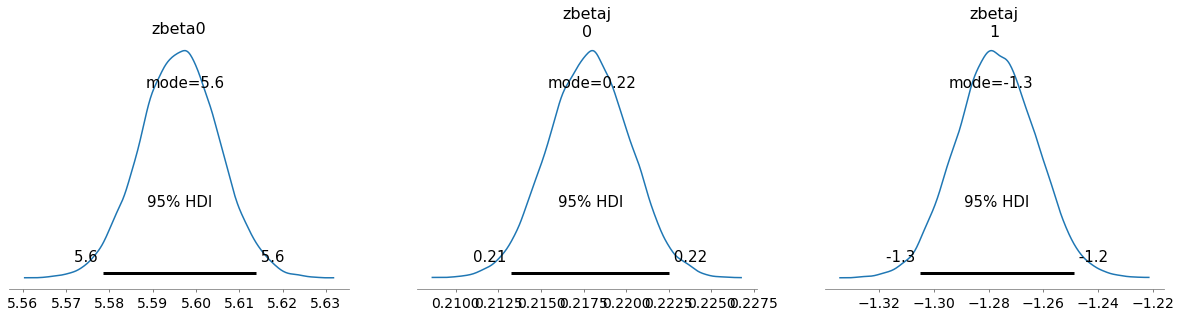

In [ ]:
az.plot_posterior(trace,['zbeta0','zbetaj'], hdi_prob=0.95, point_estimate='mode')

In [ ]:
X_test = test[['population', 'gdpPerCapita']]
y_test = test['count']

meanx = X_test.mean().values
sigmax = X_test.std().values
zX_test = ((X_test-meanx)/sigmax).values

In [ ]:
zbeta0 = 5.6
zbeta1 = 0.22
zbeta2 = -1.3

mu = np.exp(zbeta0*np.ones(20) + zbeta1*zX_test[:,0] + zbeta2*zX_test[:,1])
RMSE = mean_squared_error(mu, y, squared = False)
MAE = mae(mu,y)
print(RMSE,MAE)

415.4532159385093 349.1767267314471


**Now Testing the same for model 2 :**

In [ ]:
X_2 = train[['population', 'gdpPerCapita','corruption']]
y = train['count']

meanx_2 = X_2.mean().values
sigmax_2 = X_2.std().values
zX_2 = ((X_2-meanx_2)/sigmax_2).values

In [ ]:
with pm.Model() as glm2_test:
  zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
  zbetaj = pm.Normal('zbetaj', mu=0, sd=2, shape=(3))
  mu = pm.math.exp(zbeta0 + pm.math.dot(zbetaj, zX_2.T))
  likelihood = pm.Poisson('likelihood', mu = mu, observed = y)

In [ ]:
with glm2_test:
  trace2_test = pm.sample(10000, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [zbetaj, zbeta0]


Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 42 seconds.
The acceptance probability does not match the target. It is 0.9078033506522061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9120106841221275, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c7cf98950>,
      dtype=object)

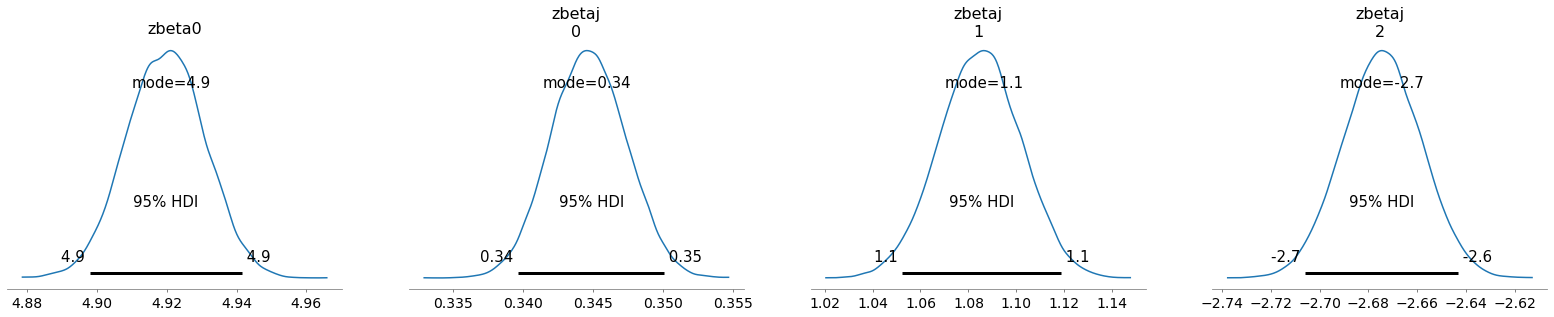

In [ ]:
az.plot_posterior(trace2,['zbeta0','zbetaj'], hdi_prob=0.95, point_estimate='mode')

In [ ]:
X_2 = test[['population', 'gdpPerCapita','corruption']]
y = test['count']

meanx_2 = X_2.mean().values
sigmax_2 = X_2.std().values
zX_2 = ((X_2-meanx_2)/sigmax_2).values

In [ ]:
zbeta0 = 4.9
zbeta1 = 0.34
zbeta2 = 1.1
zbeta3 = -2.7
mu = np.exp(zbeta0*np.ones(20) + zbeta1*zX_2[:,0] + zbeta2*zX_2[:,1] + zbeta3*zX_2[:,2])
RMSE = mean_squared_error(mu, y, squared = False)
MAE = mae(mu,y)
print(RMSE,MAE)

585.7148733223039 332.92005190113025


As the RMSE as well as MAE of the first model is lesser, so we choose the first model for modelling the data with GLM. Second model performs worse since a correlated element ['corruption'] is added.
